# Classification Network

The goal here is to classify whether the error rate is "low" "medium" or "high".
If we can successfully do this, then look at whether we can get the sign right. Start off by using the squeezenet model.


In [74]:
## Setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading data...
Pre-processing data...
0.0151999699588
Class  0  has  3016  members ( 0.3042776432606941 )
Class  1  has  3491  members ( 0.35219935431799837 )
Class  2  has  3405  members ( 0.3435230024213075 )
Organizing train/val split...
Visualizing data...
Training vs. Validation sets:


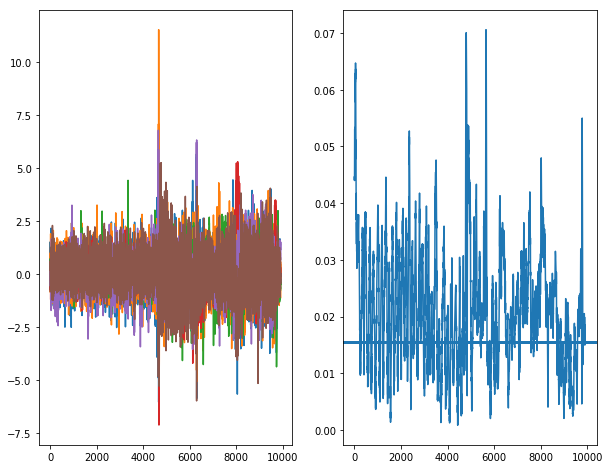

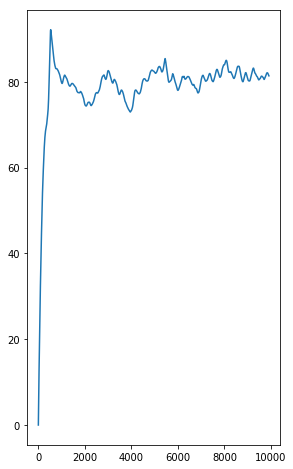

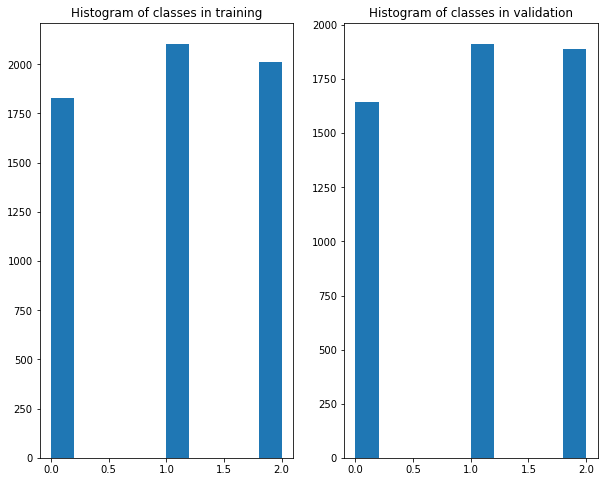

In [106]:
# Load data
# Import chelsea's data
# Check times versus times.csv
# [t, x_tango, y_tango, z_tango, x_vicon, y_vicon, z_vicon, x_err_rate, y_err_rate, z_err_rate]
# Error rates, xyz
print('Loading data...')
d_raw = (np.genfromtxt('trasnformed_data_slash_2.csv',delimiter=',')).astype(np.float32)
t_raw = d_raw[:,0]
t_img = (np.genfromtxt('rates.csv',delimiter=',')[:,0]).astype(np.float32)

## Align start of data streams
i_start = 0
for k in range(t_img.shape[0]):
    if(t_img[k]>t_raw[0]):
        i_start = k
        break
if i_start is 0:
    print('Warning! Time sequence alignment failed!')

# Extract and interpolate data
t_img = t_img[i_start:]
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[i_start:,1:7]).astype(np.float32)
y_data = np.array([np.interp(t_img, t_raw, d_raw[:,7]), np.interp(t_img, t_raw, d_raw[:,8]), np.interp(t_img, t_raw, d_raw[:,9])]).T

# Should really automate this... or just re-save file.
flows_data = []
flows_data.append(np.load('flows_lowres_1_16.npy'))
flows_data.append(np.load('flows_lowres_2_16.npy'))
flows_data.append(np.load('flows_lowres_3_16.npy'))
flows_data.append(np.load('flows_lowres_4_16.npy'))
flows_data.append(np.load('flows_lowres_5_16.npy'))
flows_data.append(np.load('flows_lowres_6_16.npy'))
flows_data.append(np.load('flows_lowres_7_16.npy'))
flows_data.append(np.load('flows_lowres_8_16.npy'))
flows_data.append(np.load('flows_lowres_9_16.npy'))
flows_data.append(np.load('flows_lowres_10_16.npy'))
flows_data.append(np.load('flows_lowres_11_16.npy'))
flows_data.append(np.load('flows_lowres_12_16.npy'))
flows_data.append(np.load('flows_lowres_13_16.npy'))
flows_data.append(np.load('flows_lowres_14_16.npy'))
flows_data.append(np.load('flows_lowres_15_16.npy'))
#flows_data.append(np.load('flows_lowres_16_16.npy'))
flows_data = np.concatenate(flows_data,axis=0)
flows_data = flows_data[i_start:,:,:,:]


print('Pre-processing data...')
# Shorten datastream:
i_start = 600 # remove initial weird-ness
i_end = flows_data.shape[0]
y_raw = y_data[i_start:i_end,:]
imu_data = imu_data[i_start:i_end,:]
flows_data = flows_data[i_start:i_end,:,:,:]

# Get sign from cumulative error:
y_cumulative = np.cumsum(y_data,axis=0)

# Convert y_data into classes:
y_norm = np.zeros(y_raw.shape[0]);
y_norm_c = np.zeros(y_raw.shape[0]+1);
for k in range(y_raw.shape[0]):
    y_norm[k]=np.linalg.norm(y_raw[k,:])
    y_norm_c[k+1] = np.linalg.norm(y_cumulative[k,:])

NUM_CLASSES = 3
# near zero
# large increasing
# large decreasing
y_std = 1.4*np.std(y_norm)
print(y_std)

y_data = np.zeros_like(y_norm)
for k in range(y_norm.shape[0]):
    if(np.abs(y_norm[k]) < y_std):
        y_data[k] = 0
        continue        
    if(y_norm_c[k+1] > y_norm_c[k]):
        y_data[k] = 1
    else:
        y_data[k] = 2
    
    
# Compute statistics: 
mean_vals= np.zeros(NUM_CLASSES)
std_vals = np.zeros(NUM_CLASSES)
for k in range(NUM_CLASSES):
    indices = np.where(y_data==k)
    mean_vals[k] = np.mean(y_norm[indices])
    std_vals[k] = np.std(y_norm[indices])
    print('Class ', k, ' has ', indices[0].shape[0], ' members (', indices[0].shape[0]/y_data.shape[0],')')


# Normalize imu data:
imu_data = imu_data - imu_data.mean(axis=0)
imu_data /= np.std(imu_data,axis=0)

# Normalize image data
flows_data -= flows_data.mean(axis=0)
flows_data /= np.std(flows_data,axis=0)

print('Organizing train/val split...')
N_training = int(0.6*flows_data.shape[0])
N_validation = flows_data.shape[0]- N_training
training_data_indices = np.random.choice(np.arange(flows_data.shape[0]), N_training)
validation_data_indices = np.setdiff1d(np.arange(flows_data.shape[0]), training_data_indices)


# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
# These need to be randomized more - getting unwanted structure in the train/val split
def sample_minibatch(batch_size, train=True,iseq=None):
    x_img_batch = np.zeros((batch_size, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
    y_batch = np.zeros(batch_size)
    
    if(iseq is None):
        # randomly sample endpoint:
        # choose which subsequence to sample from: 
        if(train):
            i_vals = training_data_indices[np.random.randint(0,N_training,batch_size)]
        else:
            i_vals = validation_data_indices[np.random.randint(0,N_validation,batch_size)]
            i_stop = 0
    else:
        i_vals = i_seq
    y_batch = y_data[i_vals]
    x_img_batch = flows_data[i_vals,:,:,:]
    return x_img_batch, y_batch

def calc_rmse(predictions, targets):
    
    return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())

print('Visualizing data...')
print('Training vs. Validation sets:')
plt.subplot(1,2,1)
plt.plot(imu_data)
plt.subplot(1,2,2)
plt.plot(y_norm)
#p = plt.axhspan(0.25, 0.75, facecolor='0.5', alpha=0.5)
plt.axhspan(y_std, y_std+0.0005)
plt.show()

plt.subplot(1,2,1)
plt.plot(y_norm_c)
plt.show()

plt.subplot(1,2,1)
plt.hist(y_data[training_data_indices])
plt.title('Histogram of classes in training')
plt.subplot(1,2,2)
plt.hist(y_data[validation_data_indices])
plt.title('Histogram of classes in validation')
plt.show()

In [77]:
BATCH_SIZE = 64

def fire_module(x,inp,sp,e11p,e33p):
    with tf.variable_scope("fire"):
        with tf.variable_scope("squeeze"):
            W = tf.get_variable("weights",shape=[1,1,inp,sp])
            b = tf.get_variable("bias",shape=[sp])
            s = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")+b
            s = tf.nn.relu(s)
        with tf.variable_scope("e11"):
            W = tf.get_variable("weights",shape=[1,1,sp,e11p])
            b = tf.get_variable("bias",shape=[e11p])
            e11 = tf.nn.conv2d(s,W,[1,1,1,1],"VALID")+b
            e11 = tf.nn.relu(e11)
        with tf.variable_scope("e33"):
            W = tf.get_variable("weights",shape=[3,3,sp,e33p])
            b = tf.get_variable("bias",shape=[e33p])
            e33 = tf.nn.conv2d(s,W,[1,1,1,1],"SAME")+b
            e33 = tf.nn.relu(e33)
        return tf.concat([e11,e33],3)

    # input is a factor of 3 skinnier and 4 shorter than expected. So pool less by a factor of 3 and 4?
    # 13x13
    # 4x3

class SqueezeNet(object):
    def extract_features(self, input=None, reuse=True):
        if input is None:
            input = self.image
        x = input
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('layer0'):
                W = tf.get_variable("weights",shape=[3,3,2,64])
                b = tf.get_variable("bias",shape=[64])
                x = tf.nn.conv2d(x,W,[1,2,2,1],"VALID")
                x = tf.nn.bias_add(x,b)
                layers.append(x)
            with tf.variable_scope('layer1'):
                x = tf.nn.relu(x)
                layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer3'):
                x = fire_module(x,64,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer4'):
                x = fire_module(x,128,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer5'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer6'):
                x = fire_module(x,128,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer7'):
                x = fire_module(x,256,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer8'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer9'):
                x = fire_module(x,256,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer10'):
                x = fire_module(x,384,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer11'):
                x = fire_module(x,384,64,256,256)
                layers.append(x)
            with tf.variable_scope('layer12'):
                x = fire_module(x,512,64,256,256)
                layers.append(x)
        return layers

    def __init__(self, save_path=None, sess=None):
        """Create a SqueezeNet model.
        Inputs:
        - save_path: path to TensorFlow checkpoint
        - sess: TensorFlow session
        """
        self.image = tf.placeholder('float',shape=[None,None,None,2],name='input_image')
        self.labels = tf.placeholder('int32', shape=[None], name='labels')
        self.lr = tf.placeholder('float',shape=[1],name='lr')
        self.layers = []
        x = self.image
        self.layers = self.extract_features(x, reuse=False)
        self.features = self.layers[-1]
        with tf.variable_scope('classifier'):
            with tf.variable_scope('layer0'):
                x = self.features
                self.layers.append(x)
            with tf.variable_scope('layer1'):
                W = tf.get_variable("weights",shape=[1,1,512,1000])
                b = tf.get_variable("bias",shape=[1000])
                x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
                x = tf.nn.bias_add(x,b)
                self.layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.relu(x)
                self.layers.append(x)
            with tf.variable_scope('layer3'):
                x = tf.nn.avg_pool(x,[1,2,3,1],strides=[1,2,1,1],padding='VALID')
                self.layers.append(x)
# NOT really squeezenet, but ...
            with tf.variable_scope('layer4'):
                x = tf.layers.dense(x, NUM_CLASSES)
                self.layers.append(x)
        self.classifier = tf.reshape(x,[BATCH_SIZE, NUM_CLASSES])

        if save_path is not None:
            saver = tf.train.Saver()
#            saver = tf.train.import_meta_graph(save_path*'.meta')
            saver.restore(sess, save_path)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.labels, NUM_CLASSES), logits=self.classifier))
        self.prediction = tf.cast(tf.argmax(self.classifier,1),'int32')
        self.acc = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.labels),tf.float32))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr[0]).minimize(self.loss)


Step:  1000  Train:  0.40625  Val:  0.375 loss 1.08868 LR:  0.00048376129234188364


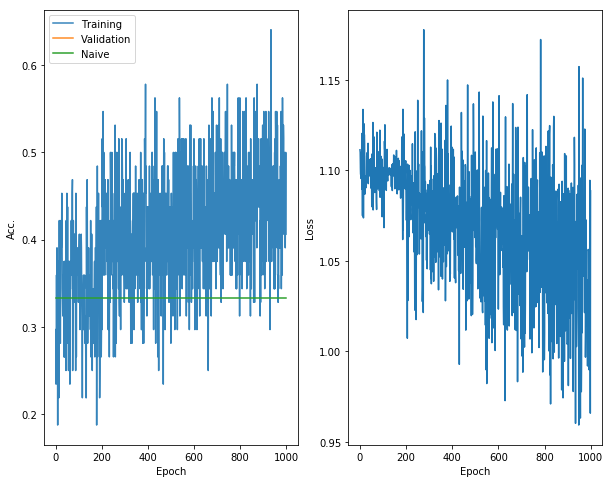

Step:  2000  Train:  0.53125  Val:  0.46875 loss 0.974365 LR:  0.0004680499759365788


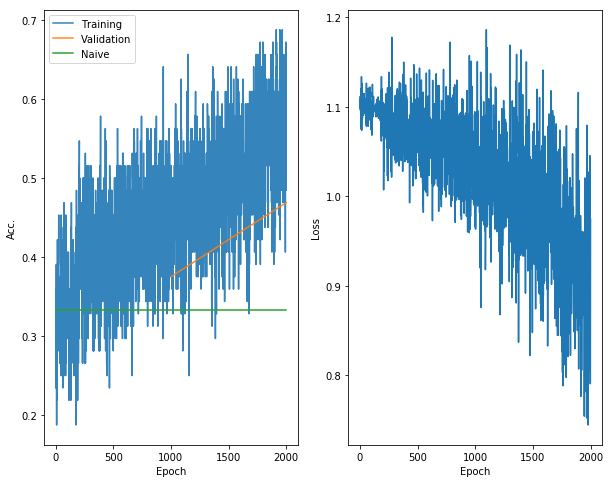

Step:  3000  Train:  0.765625  Val:  0.5 loss 0.505354 LR:  0.00045284892247933375


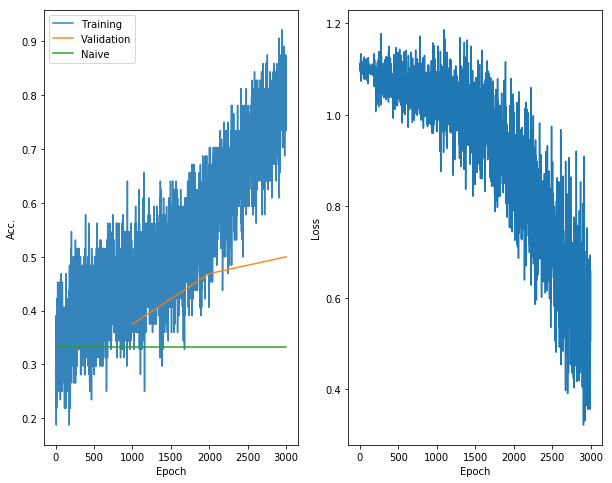

Step:  4000  Train:  0.890625  Val:  0.640625 loss 0.212121 LR:  0.0004377034183885155


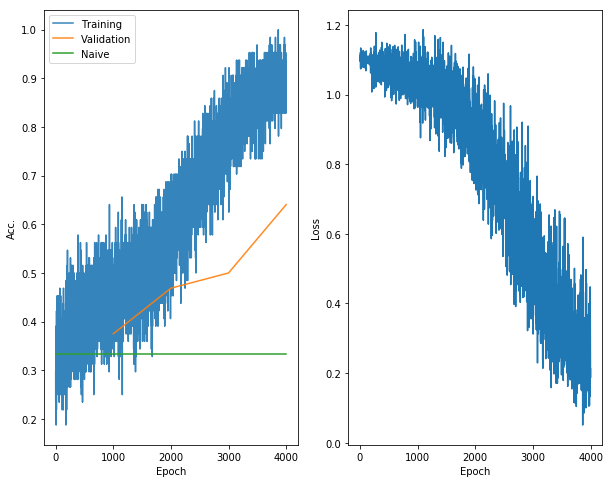

Step:  5000  Train:  0.96875  Val:  0.578125 loss 0.0922492 LR:  0.000423487942684177


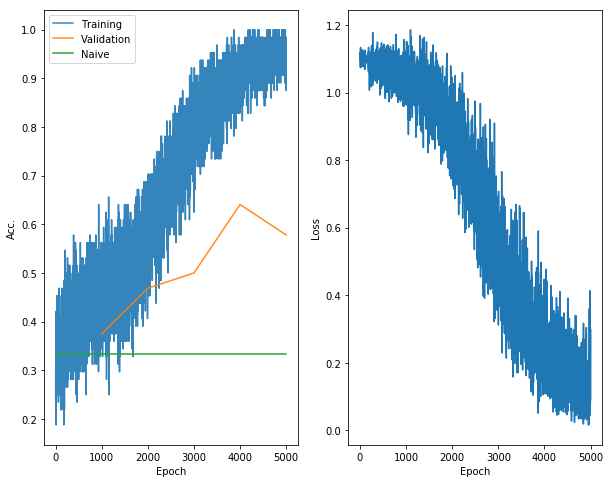

Done.


In [113]:
tf.reset_default_graph() # remove all existing variables in the graph 
sess = get_session() # start a new Session

# simple parameters:
disp_period = 1000
training_iters = 5000
lr = 0.0005
lr_decay=0.999

with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    model = SqueezeNet(sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []
    train_inds = []

    naive_val = 1/NUM_CLASSES
    
    # Launch the graph
    sess.run(init)
    step = 1
    loss_hist = []
    train_inds = []
    val_inds = []
    # Keep training until reach max iterations
    while step  < training_iters:
        if step % 30 is 0:
            lr *= lr_decay
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x, batch_y = sample_minibatch(BATCH_SIZE)        
        
#        print('Batch_y shape:', batch_y.shape)
        # Run optimization op (backprop)
#                self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
#        self.labels = tf.placeholder('int32', shape=[None], name='labels')
#        self.lr = tf.placeholder('float',shape[1],name='lr')

        o,loss,acc_t = sess.run([model.optimizer,model.loss, model.acc], feed_dict={model.image: batch_x, model.labels: batch_y, model.lr:[lr]})
        # Compute accuracy:
        train_inds.append(step)
        train_history.append(acc_t)
        loss_hist.append(loss)
        
        step += 1
        if step % disp_period is 0:
            # Calculate val accuracy:
            batch_x, batch_y = sample_minibatch(BATCH_SIZE, False)
            acc_v = sess.run(model.acc, feed_dict={model.image: batch_x, model.labels: batch_y})
            val_history.append(acc_v)
            val_inds.append(step)
            
            print('Step: ', step, ' Train: ', acc_t, ' Val: ', acc_v, 'loss',loss_hist[-1], 'LR: ', lr)
            plt.subplot(1,2,1)
            plt.plot(train_inds, train_history,alpha=0.9)
            plt.plot(val_inds, val_history,alpha=0.9)
            plt.plot([0,step], [naive_val,naive_val])
            plt.legend(['Training','Validation','Naive'])
            plt.xlabel('Epoch')
            plt.ylabel('Acc.')
            plt.subplot(1,2,2)
            plt.plot(train_inds,loss_hist)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
    # Compute sequence prediction:
print('Done.')


In [114]:
# Reconstruct signal using a randomwalk model:
print('Computing sequence prediction - this may take a while. ')
y_pred = np.zeros_like(y_data)

for k in range(0,flows_data.shape[0]-(flows_data.shape[0]%BATCH_SIZE),BATCH_SIZE):
    if k % 1000 is 0:
        print('k = ', k)
    pred = sess.run(model.prediction, feed_dict={model.image: flows_data[k:k+BATCH_SIZE,:,:,:], model.labels: y_data[k:k+BATCH_SIZE]})
    y_pred[k:k+BATCH_SIZE] = pred
    


Computing sequence prediction - this may take a while. 
k =  0
k =  8000


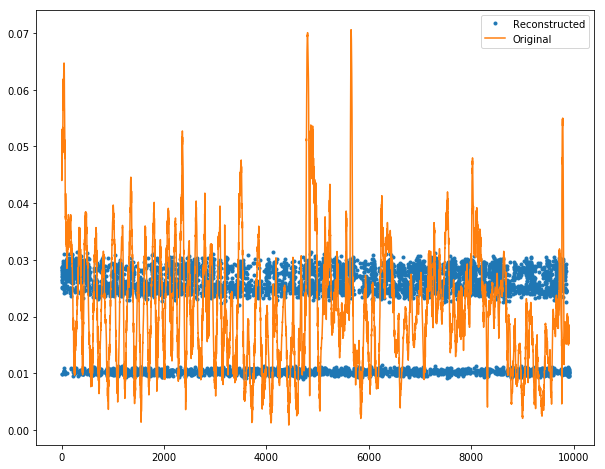

In [119]:
reconstructed_signal= np.zeros(y_pred.shape[0])
for k in range(y_pred.shape[0]):
    c = np.int(y_pred[k])
    reconstructed_signal[k] =  mean_vals[c]+0.1*std_vals[c]*np.random.randn()
plt.plot(reconstructed_signal,'.')
plt.plot(y_norm)
plt.legend(['Reconstructed','Original'])

plotting from  300  to  500
High correlation (near 1) means we are predicting well.
Correlation between error and signal: 0.590798321159


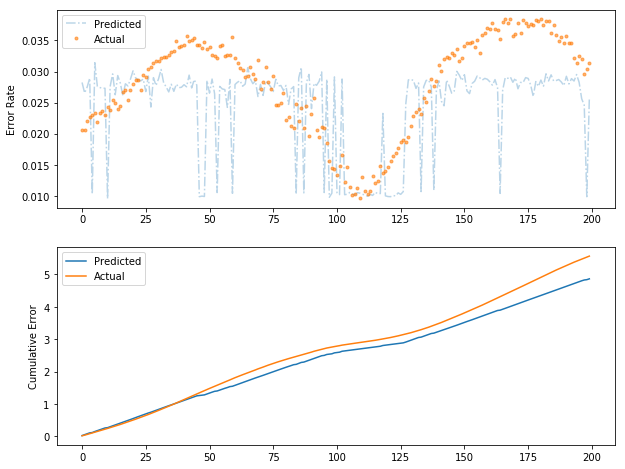

High correlation (near 1) means we are predicting noise.
Correlation between error and signal: 0.51918855097


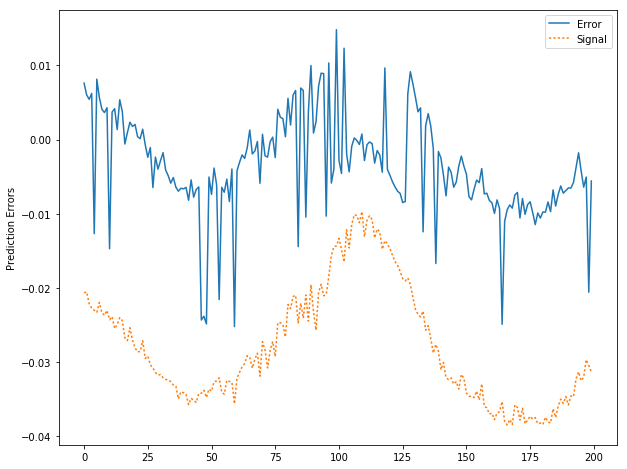

In [121]:
# Can load a previously computed prediction - useful if cold starting a notebook.
r = reconstructed_signal

# Blue background corresponds to data used during training
def plot_data(ns, ne):    

    print('plotting from ', ns, ' to ', ne)
    
    print('High correlation (near 1) means we are predicting well.')
    m1 = y_norm[ns:ne].mean()
    c1 = np.sqrt(np.correlate(y_norm[ns:ne]-m1,y_norm[ns:ne]-m1)[0])
    m2 = r[ns:ne].mean()
    c2 = np.sqrt(np.correlate(r[ns:ne]-m2,r[ns:ne]-m2)[0])
    c12 = (np.correlate(y_norm[ns:ne]-m1,r[ns:ne]-m2))[0]/(c1*c2)
    print('Correlation between error and signal:', (np.abs(c12)))
    
    plt.subplot(2,1,1)
    plt.ylabel('Error Rate')
    plt.plot(r[ns:ne],'-.',alpha=0.3)
    plt.plot(y_norm[ns:ne],'.',alpha=0.6)
#        plt.axvspan(0,N_training, facecolor='b',alpha=0.1)
    plt.legend(['Predicted','Actual'])

    plt.subplot(2,1,2)
    plt.ylabel('Cumulative Error')
    plt.plot(np.cumsum(r[ns:ne]))
    plt.plot(np.cumsum(y_norm[ns:ne]))
#        plt.axvspan(0,N_training, facecolor='b',alpha=0.1)
    plt.legend(['Predicted','Actual'])
    plt.show()

def plot_error(ns, ne):
    print('High correlation (near 1) means we are predicting noise.')
    m1 = y_norm[ns:ne].mean()
    c1 = np.sqrt(np.correlate(y_norm[ns:ne]-m1,y_norm[ns:ne]-m1)[0])
    m2 = np.mean(r[ns:ne]-y_norm[ns:ne])
    c2 = np.sqrt(np.correlate(r[ns:ne]-m2-y_norm[ns:ne],r[ns:ne]-m2-y_norm[ns:ne])[0])
    c12 = (np.correlate(y_norm[ns:ne]-m1,r[ns:ne]-y_norm[ns:ne]-m2))[0]/(c1*c2)
    print('Correlation between error and signal:', (np.abs(c12)))
    
    plt.ylabel('Prediction Errors')
    plt.plot(r[ns:ne]-y_norm[ns:ne])
    plt.plot(-y_norm[ns:ne],':')
    plt.legend(['Error', 'Signal'])
    plt.show()


#plt.title('Learning Curve')
#naive_val = 0
#for k in range(y_data.shape[0]):
#    naive_val += calc_rmse(y_data[k,:],np.zeros(OUTPUT_DIM))
#naive_val /= y_data.shape[0]

#plt.plot(train_history,'.',alpha=0.3)
#plt.plot(val_history,'.',alpha=0.3)
#plt.plot(naive_val*np.ones_like(train_history),':')
#plt.legend(['Training','Validation','Naive'])
#plt.xlabel('Epoch')
#plt.ylabel('RMSE')
#plt.show()


plot_data(300,500)
plot_error(300,500)


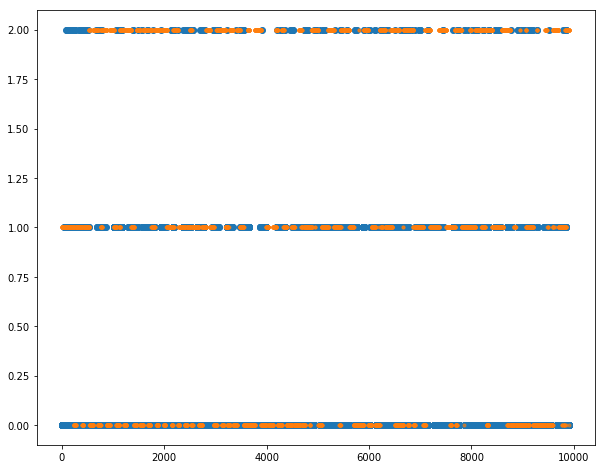

In [111]:
plt.plot(y_pred,'o')
plt.plot(y_data,'.',alpha=0.6)